In [ ]:
!pip install wfdb numpy pandas matplotlib tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 2.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import wfdb
import numpy as np
import pandas as pd

data = '/content/drive/MyDrive/mitdb1'


patients = [f.split('.')[0] for f in os.listdir(data) if f.endswith('.hea')]
patients = np.sort(patients)
labels_df = pd.DataFrame()

for pat_id in patients:
    file = os.path.join(data, pat_id)
    annotation = wfdb.rdann(file, 'atr')

    #sym is the annotated symbol read from the file
    labels = annotation.symbol

    #values is the different symbols in each patient
    #counts is the number of each symbol for said patient
    vals, cts = np.unique(labels, return_counts=True)

    #df_sub is a mini lil dataframe for each individual patient
    df_per_pat = pd.DataFrame({'Symbol':vals, 'Counts':cts, 'Patient':[pat_id]*len(cts)})
    labels_df = pd.concat([labels_df, df_per_pat],axis = 0)

labels_df.groupby('Symbol').Counts.sum().sort_values(ascending = False)

Symbol
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: Counts, dtype: int64

In [ ]:
print(np.unique(labels_df.Symbol))
print(len(np.unique(labels_df.Symbol)))

['!' '"' '+' '/' 'A' 'E' 'F' 'J' 'L' 'N' 'Q' 'R' 'S' 'V' '[' ']' 'a' 'e'
 'f' 'j' 'x' '|' '~']
23


In [ ]:
# For first stage, consider N as normal heartbeats, all others are irregular or noise (according to found article).
irregular = ['L','R','V','/','A','f','F','j','a','E','J','e','S']
regular = ['N']

In [ ]:
def categorize_heartbeat(symbol):

    if symbol in regular:
        return 0

    elif symbol in irregular:
        return 1

    else:
        return -1

In [ ]:
# used to load in the entire ECG dataset,
# get the signal and label,
# read the symbols and signal

def load_ecg(file):

    record = wfdb.rdrecord(file)
    annotation = wfdb.rdann(file, 'atr')
    p_signal = record.p_signal
    symbol_ann = annotation.symbol
    sample_ann = annotation.sample

    return p_signal, symbol_ann, sample_ann

In [ ]:
# creates dataset for model training

def make_dataset(patients, seconds, frequency, irregular):

  #set number of data points
  columns = 2 * seconds * frequency
  data_X = np.zeros((1,columns))
  data_Y = np.zeros((1,1))
  data_Labels = []

  rows_per_patient = []

  for pat in patients:
    file = os.path.join(data, pat)
    p_signal, symbol_ann, sample_ann = load_ecg(file)

    # only using one lead for simplicity
    p_signal = p_signal[:,0]

    # make df without the noise symbols
    df_data = pd.DataFrame({'symbol_ann':symbol_ann,
                          'sample_ann':sample_ann})
    df_data = df_data.loc[df_data.symbol_ann.isin(irregular + regular)]

    #X,Y,symbs = build_XY(p_signal,df_data, columns, irregular)

    rows = len(df_data)
    X = np.zeros((rows, columns))
    Y = np.zeros((rows,1))
    symbs = []

    # keep track of rows
    maximum_rows = 0

    for sample_ann, symbol_ann in zip(df_data.sample_ann.values,df_data.symbol_ann.values):
        left = max([0,(sample_ann - seconds * frequency) ])
        right = min([len(p_signal),(sample_ann + seconds * frequency) ])
        x = p_signal[left: right]
        if len(x) == columns:
            X[maximum_rows,:] = x
            Y[maximum_rows,:] = int(symbol_ann in irregular)
            symbs.append(symbol_ann)
            maximum_rows += 1
    X = X[:maximum_rows,:]
    Y = Y[:maximum_rows,:]

    data_Labels = data_Labels+symbs
    rows_per_patient.append(X.shape[0])
    data_X = np.append(data_X,X,axis = 0)
    data_Y = np.append(data_Y,Y,axis = 0)
    data_X = data_X[1:,:]
    data_Y = data_Y[1:,:]

  return data_X, data_Y, data_Labels

In [ ]:
def build_XY(p_signal, df_ann, num_cols, abnormal):
  # this function builds the X,Y matrices for each beat
  # it also returns the original symbols for Y
  # take each annotation in df_ann, turn into a row of the X dataset
  # each row is now a heartbeat annotation with corresponding signal
  # column is built using a p signal

  num_rows = len(df_ann)

  X = np.zeros((num_rows, num_cols))
  Y = np.zeros((num_rows,1))
  sym = []

  # keep track of rows
  max_row = 0

  for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):
      left = max([0,(atr_sample - num_sec*fs) ])
      right = min([len(p_signal),(atr_sample + num_sec*fs) ])
      x = p_signal[left: right]
      if len(x) == num_cols:
          X[max_row,:] = x
          Y[max_row,:] = int(atr_sym in abnormal)
          sym.append(atr_sym)
          max_row += 1
  X = X[:max_row,:]
  Y = Y[:max_row,:]
  return X,Y,sym

In [ ]:
X_data, Y_data, symbol_data = make_dataset(patients, 3, 360, irregular)


In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_valid, y_train, y_valid = train_test_split(X_data, Y_data, test_size=0.3, random_state=42)

In [ ]:
df4 = pd.DataFrame(X_train)

df4

,0,1,2,3,4,5,6,7,8,9,...,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159
0,-0.160,-0.135,-0.130,-0.140,-0.155,-0.155,-0.160,-0.140,-0.140,-0.135,...,-0.430,-0.425,-0.410,-0.420,-0.420,-0.425,-0.405,-0.385,-0.380,-0.380
1,-0.310,-0.320,-0.325,-0.330,-0.350,-0.350,-0.320,-0.310,-0.290,-0.275,...,-0.125,-0.155,-0.160,-0.170,-0.180,-0.195,-0.200,-0.205,-0.225,-0.220
2,-0.230,-0.215,-0.210,-0.200,-0.215,-0.200,-0.210,-0.200,-0.210,-0.235,...,-0.145,-0.150,-0.150,-0.140,-0.145,-0.145,-0.155,-0.175,-0.180,-0.185
3,-0.700,-0.705,-0.710,-0.725,-0.730,-0.755,-0.750,-0.755,-0.740,-0.750,...,-0.205,-0.225,-0.240,-0.255,-0.265,-0.280,-0.325,-0.370,-0.405,-0.420
4,0.245,0.240,0.240,0.240,0.255,0.260,0.275,0.305,0.325,0.335,...,-0.260,-0.285,-0.290,-0.315,-0.325,-0.330,-0.325,-0.330,-0.340,-0.355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76331,-0.400,-0.375,-0.385,-0.380,-0.380,-0.390,-0.375,-0.360,-0.360,-0.350,...,0.410,0.235,0.055,-0.040,0.000,0.110,0.195,0.220,0.190,0.185
76332,-0.265,-0.260,-0.250,-0.265,-0.260,-0.280,-0.275,-0.255,-0.240,-0.250,...,-0.315,-0.285,-0.290,-0.335,-0.325,-0.315,-0.305,-0.295,-0.290,-0.280
76333,-0.245,-0.235,-0.230,-0.220,-0.220,-0.215,-0.230,-0.235,-0.240,-0.250,...,-0.200,-0.195,-0.190,-0.190,-0.190,-0.190,-0.190,-0.190,-0.185,-0.185
76334,-0.545,-0.460,-0.340,-0.220,-0.115,-0.010,0.115,0.280,0.495,0.700,...,-0.430,-0.425,-0.430,-0.440,-0.440,-0.455,-0.435,-0.430,-0.440,-0.435


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_data.shape)

(76336, 2160)
(76336, 1)
(32716, 2160)
(32716, 1)
(109052, 2160)


In [ ]:
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid_cnn = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

print(X_train_cnn.shape)
print(X_valid_cnn.shape)

(73064, 2160, 1)
(35988, 2160, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models


model = models.Sequential()
model.add(layers.Conv1D(64, 3, activation='relu', input_shape=(2160,1)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_valid, y_valid)
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/2
2284/2284 [==============================] - 939s 410ms/step - loss: 0.1387 - accuracy: 0.9502 - val_loss: 0.0755 - val_accuracy: 0.9757
Epoch 2/2
1125/1125 [==============================] - 81s 72ms/step - loss: 0.0564 - accuracy: 0.9817
Test Accuracy: 0.9816605448722839


1125/1125 [==============================] - 102s 91ms/step


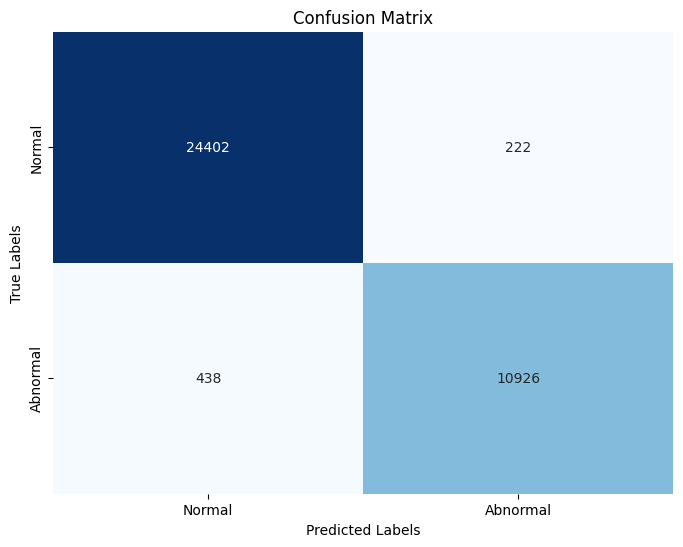

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_valid)
y_pred_binary = np.round(y_pred).flatten()

conf_matrix = confusion_matrix(y_valid, y_pred_binary)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Abnormal'],  # Replace with your class labels
            yticklabels=['Normal', 'Abnormal'])  # Replace with your class labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report


print("Classification Report:")
print(classification_report(y_valid, y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     24624
         1.0       0.98      0.96      0.97     11364

    accuracy                           0.98     35988
   macro avg       0.98      0.98      0.98     35988
weighted avg       0.98      0.98      0.98     35988

